## 6.1. 텍스트 데이터 다루기
- 문서 분류, 감성 분석, 저자 식별, 질문응답 등의 애플리케이션에 적합
- 문자 언어에 대한 통계적 구조를 만들어 간단한 텍스트 문제를 해결한다

- 텍스트를 수치형 텐서로 변환하는 과정을 텍스트 벡터화(vectorizing text)라고 한다.
  - 벡터화하는 방법
    - 텍스트를 단어로 나누고, 각 단어를 하나의 벡터로 변환한다.
    - 텍스트를 문자로 나누고, 각 문자를 하나의 벡터로 변환한다.
    - 텍스트에서 단어나 문자의 n-gram을 추출하여, 각 n-gram을 하나의 벡터로 변환한다.
      - n-gram은 연속된 단어나 문자의 그룹, 텍스트에서 단어나 문자를 하나씩 이동하며 추출한다.
  
  - 텍스트를 나누는 단위 : 토큰(token)
    - 텍스트를 토큰으로 나눈 작업 : 토큰화(toeknization)
    - 원-핫 인코딩 / 토큰 임베딩
    - 단어 임베딩

In [ ]:
# 단어 원-핫 인코딩하기

import numpy as np

samples=['The cat sat on the mat.', 'The dog ate my homework.']

token_index = {} 

for sample in samples:
  for word in sample.split():
    if word not in token_index:
      token_index[word]=len(token_index)+1 # 단어마다 고유한 인덱스 (1부터)
max_length=10

results = np.zeros(shape=(len(samples), max_length, max(token_index.values())+1))

for i, sample in enumerate(samples):
  for j, word in list(enumerate(sample.split()))[:max_length]:
    index = token_index.get(word)
    results[i,j,index]=1.

In [ ]:
# 문자 수준 원-핫 인코딩하기

import string

samples=['The cat sat on the mat.', 'The dog ate my homework.']
characters = string.printable # 출력 가능한 모든 아스키 문자
token_index = dict(zip(characters, range(1, len(characters)+1)))

max_length = 50
results = np.zeros((len(samples), max_length, max(token_index.values())+1))
for i, sample in enumerate(samples):
  for j, character in enumerate(sample):
    index = token_index.get(character)
    results[i,j,index]=1.

In [ ]:
# Keras 를 사용한 단어 수준의 원-핫 인코딩
from keras.preprocessing.text import Tokenizer

samples=['The cat sat on the mat.', 'The dog ate my homework.']

tokenizer = Tokenizer(num_words=1000) # 가장 빈도가 높은 단어 1000개만 선택하는 객체 생성
tokenizer.fit_on_texts(samples) # 단어 인덱스 구축

sequences = tokenizer.texts_to_sequences(samples) # 문자열(samples)을 정수 인덱스의 리스트로 반환

one_hot_results = tokenizer.texts_to_matrix(samples, mode='binary') # 직접 원-핫 이진 벡터 얻기

word_index = tokenizer.word_index
print("%s개의 고유한 토큰을 찾았음."% len(word_index))

9개의 고유한 토큰을 찾았음.


In [ ]:
# 원-핫 해싱 기법
# 어휘 사전에 있는 고유한 토큰의 수가 너무 많은 경우 사용

samples=['The cat sat on the mat.', 'The dog ate my homework.']

dimensionality = 1000 # 단어의 크기가 1,000인 벡터로 저장 (그 이상이면 해싱 충돌이 일어나 정확도 감소)
max_length = 10

results = np.zeros((len(samples), max_length, dimensionality))

for i,sample in enumerate(samples):
  for j, word in list(enumerate(sample.split()))[:max_length]:
    index = abs(hash(word)) % dimensionality
    results[i,j,index]=1.

### 단어 임베딩 vs 원-핫 인코딩
- 원-핫 인코딩으로 만든 벡터는 희소(sparse)하고 고차원적이다
  - 대부분 0으로 채워지고, 어휘 사전에 있는 단어의 수와 차원이 같다
  - 2만개의 토큰의 어휘 사전은 2만 차원 또는 그 이상임

- 단어 임베딩은 저차원의 실수형 벡터이다
  - 데이터로부터 학습, 밀집되어있음
  - 256/512 차원, 큰 데이터의 경우 1024차원

### 단어 임베딩 만드는 방법
- 1. (문서 분류나 감성 예측 같은) 관심 대상인 문제와 함께 단어 임베딩을 학습
  - 랜덤한 단어 벡터로 시작하여 신경망의 가중치를 학습하는 것과 같은 방식으로 단어 벡터 학습
- 2. 다른 머신 러닝 작업에서 미리 계산된 단어 임베딩을 로드한다
  - 사전 훈련된 단어 임베딩(pretrained word embedding)

- Embedding 층을 사용하여 단어 임베딩 학습하기
  - 단어 벡터 사이에 좀 더 추상적이고 기하학적인 관계를 얻기 위해서는 단어간의 의미 관계를 반영해야한다
  -  i.e. 동의어는 비슷한 단어 벡터로 임베딩, 같은 부류는 비슷한 벡터로 만들어짐
- 좋은 단어 임베딩 공간을 만드는 것은 문제에 따라 크게 달라진다
  - i.e. 영화 리뷰 분석 모델, 법률 분석 모델 두 개는 서로 다른 임베딩 공간을 갖는다.
  - 따라서 새로운 작업에는 새로운 임베딩을 학습해야 한다.
  - Keras 활용해서 간단하게 만들 수 있다

In [2]:
# Embedding 층의 객체 생성하기
from keras.layers import Embedding

embedding_layer = Embedding(1000, 64)
# embedding 층은 적어도 2개의 매개 변수를 받는다
# 가능한 토큰의 개수 1000개와 임베딩 차원(64)

# Embedding 층
# 단어 인덱스 -> Embedding 층 -> 연관된 단어 벡터

# Embedding 층은 크기가 (samples, sequence_length)인 2D 정수 텐서를 입력으로 받는다
# 시퀀스 길이가 짧으면 0 으로 채워지고
# 시퀀스 길이가 길면 잘린다

In [3]:
# Embedding 층은 크기가 (samples, sequence_length, embedding_dimensionality)인 3D 실수형 텐서 반환
# RNN 층이나 1D 합성곱 층에서 처리

In [4]:
# 예시
# IMDB 영화 리뷰 감성 예측 문제

## Embedding 층에 사용할 IMDB 로드하기
from keras.datasets import imdb
from keras import preprocessing

max_features = 10000 # 특성으로 사용할 단어의 수
max_len = 20 # 사용할 텍스트의 길이 (20개만 사용한다)

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=max_len) # 리스트를 (samples, maxlen)크기의 2D 텐서로 전환
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=max_len)

## IMDB데이터에 Embedding 층과 분류기 사용하기
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding
model = Sequential()
model.add(Embedding(10000, 8, input_length=max_len)) # 텐서의 출력 (samples, max_len, 8) -> (None, 20, 8)
model.add(Flatten()) # 3D 임베딩 텐서를 (samples, maxlen*8)크기의 2D 텐서로 전환
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

17473536/17464789 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 20, 8)             80000     
                                                                 
 flatten (Flatten)           (None, 160)               0         
                                                                 
 dense (Dense)               (None, 1)                 161       
                                                                 
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
625/625 [==============================] - 3s 3ms/step - loss: 0.6710 - acc: 0.6180 - val_loss: 0.6243 - val_acc: 0.6986
Epoch 2/10
625/625 [==============================] - 2s 3ms/step - loss: 0.5507 - acc: 0.7488 - val_loss: 0.5322 - val

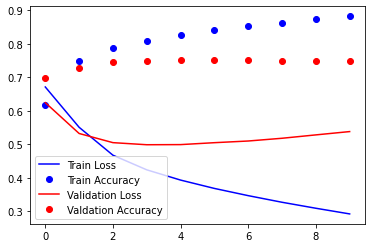

In [12]:
import matplotlib.pyplot as plt
history_dict = history.history

plt.plot(history_dict['loss'],'b', color='b', label='Train Loss')
plt.plot(history_dict['acc'],'bo', color='b', label='Train Accuracy')
plt.plot(history_dict['val_loss'],'b',color='r',label='Validation Loss')
plt.plot(history_dict['val_acc'], 'bo', color='r',label='Valdation Accuracy')
plt.legend()
plt.show()

*** 결과  ***

약 75% 의 검증 정확도가 나옴
- 20 개의 단어만 사용했는데 괜찮게 나옴
- 임베딩 시퀀스를 펼치고 하나의 Dense층을 훈련했으므로, 입력 시퀀스에 있는 각 단어는 독립적으로 다루었음
  - i.e. this movie is a bomb, this movie is the bomb 을 부정적인 리뷰로 동일하게 다룸
  - 따라서 각 시퀀스 전체를 고려한 특성을 학습하기 위해서는 임베딩 층 위에 순환 층이나, 1D 합성곱 층을 추가해야한다

---

#### 훈련 데이터 부족한 경우

- 미리 계산된 임베딩 공간에서 임베딩 벡터 로드하기
  - 뛰어난 구조와 유용한 성질을 가지고 있어, 언어 구조의 일반적인 측면을 잡아낼 수 있다.
  - 일반적인 특성이 필요할 때 주로 사용한다.

- 단어 임베딩은 일반적으로 단어 출현 통계를 사용하여 계산된다
  - 신경망 사용하는 방법
  - 신경망 사용하지 않는 방법

- 종류
  - Word2vec
  - GloVe
     - 단어의 동시 출현 통계를 기록한 행렬을 분해하는 기법을 사용

### 모든 내용 적용하기 : 원본 텍스트 ~ 단어 임베딩

- 문장을 벡터의 시퀀스로 임베딩하고, 펼쳐, 그 위에 Dense층을 훈련한다




In [18]:
!wget --no-check-certificate 'http://mng.bz/0tIo'

--2021-12-20 05:49:43--  http://mng.bz/0tIo
Resolving mng.bz (mng.bz)... 35.166.24.88
Connecting to mng.bz (mng.bz)|35.166.24.88|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://mng.bz/0tIo [following]
--2021-12-20 05:49:43--  https://mng.bz/0tIo
Connecting to mng.bz (mng.bz)|35.166.24.88|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 301 
Location: http://s3.amazonaws.com/text-datasets/aclImdb.zip [following]
--2021-12-20 05:49:43--  http://s3.amazonaws.com/text-datasets/aclImdb.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.38.118
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.38.118|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60711700 (58M) [application/zip]
Saving to: ‘0tIo’

0tIo                100%[===================>]  57.90M  32.0MB/s    in 1.8s    

2021-12-20 05:49:45 (32.0 MB/s) - ‘0tIo’ saved [60711700/60711700]

In [19]:
!unzip 0tIo

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: __MACOSX/aclImdb/train/pos/._7754_9.txt  
  inflating: aclImdb/train/pos/7755_9.txt  
  inflating: __MACOSX/aclImdb/train/pos/._7755_9.txt  
  inflating: aclImdb/train/pos/7756_10.txt  
  inflating: __MACOSX/aclImdb/train/pos/._7756_10.txt  
  inflating: aclImdb/train/pos/7757_9.txt  
  inflating: __MACOSX/aclImdb/train/pos/._7757_9.txt  
  inflating: aclImdb/train/pos/7758_7.txt  
  inflating: __MACOSX/aclImdb/train/pos/._7758_7.txt  
  inflating: aclImdb/train/pos/7759_10.txt  
  inflating: __MACOSX/aclImdb/train/pos/._7759_10.txt  
  inflating: aclImdb/train/pos/775_7.txt  
  inflating: __MACOSX/aclImdb/train/pos/._775_7.txt  
  inflating: aclImdb/train/pos/7760_10.txt  
  inflating: __MACOSX/aclImdb/train/pos/._7760_10.txt  
  inflating: aclImdb/train/pos/7761_10.txt  
  inflating: __MACOSX/aclImdb/train/pos/._7761_10.txt  
  inflating: aclImdb/train/pos/7762_8.txt  
  inflating: __MACOSX/aclImdb/train/pos/._7762_8.txt  
  inflating:

In [20]:
import os
imdb_dir = '/content/aclImdb'
train_dir = os.path.join(imdb_dir, 'train')
labels = []
texts = []

for label_type in ['neg','pos']:
  dir_name = os.path.join(train_dir, label_type) # neg, pos 의 경로
  for fname in os.listdir(dir_name): # 모든 파일 읽어오기
    if fname[-4:]=='.txt':
      f = open(os.path.join(dir_name, fname), encoding='utf8')
      texts.append(f.read()) # 각 파일 내용 저장
      f.close()
      if label_type == 'neg':
        labels.append(0)
      else:
        labels.append(1)

In [22]:
# 데이터 토큰화

# 텍스트를 벡터로 만들고 훈련 세트와 검증 세트로 나눈다
# 훈련 데이터를 처음 200개의 샘플로 제한한다
# 200개의 샘플을 학습한 후 영화 리뷰를 분류

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 100 # 100개 단어 이후를 버림
training_samples = 200 # 200개의 훈련 샘플
validation_samples= 10000 #  검증 샘플 1만개
max_words = 10000  # 데이터셋에서 가장 빈도수가 높은 1만개만 활용

tokenizer = Tokenizer(num_words = max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print("%s개의 고유한 토큰을 찾았습니다." % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)
labels= np.asarray(labels)
print("데이터 텐서의 크기 :", data.shape)
print("레이블 텐서의 크기 :", labels.shape)

# 데이터를 훈련/검증 세트로 분할
indices = np.arange(data.shape[0]) 
np.random.shuffle(indices) # 샘플이 순서대로 있기 때문에, 데이터를 섞어준다
data = data[indices]
labels = labels[indices]

x_train= data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples : training_samples + validation_samples]
y_val = labels[training_samples : training_samples + validation_samples]

88582개의 고유한 토큰을 찾았습니다.
데이터 텐서의 크기 : (25000, 100)
레이블 텐서의 크기 : (25000,)


In [23]:
## GloVe 단어 임베딩 내려받기
!wget --no-check-certificate 'https://nlp.stanford.edu/data/glove.6B.zip'

--2021-12-20 06:05:11--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-12-20 06:05:11--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.15MB/s    in 2m 39s  

2021-12-20 06:07:50 (5.16 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



In [24]:
!unzip -uq '/content/glove.6B.zip' -d '/content/datasets'

In [26]:
os.mkdir('/content/datasets')
glove_dir = '/content/datasets'

embedding_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'), encoding='utf8')
for line in f :
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embedding_index[word] = coefs
f.close()

print("%s개의 단어 벡터를 찾았습니다." % len(embedding_index))

400000개의 단어 벡터를 찾았습니다.


In [27]:
# Embedding 층에 주입할 수 있도록 임베딩 행렬을 만들어 준다
# (max_words, embedding_dim)의 크기를 가진다.
# 이 행렬의 i 번째 원소는 단어 인덱스의 i번째 단어에 상응하는 embedding_dim 차원 벡터이다

embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items(): # 단어 사전
  if i < max_words: # 1000개 해당이면?
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector # 임베딩 인덱스에 없는 단어는 모두 0이 된다

In [28]:
# 모델 정의하기

from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length = maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 100)          1000000   
                                                                 
 flatten_1 (Flatten)         (None, 10000)             0         
                                                                 
 dense_1 (Dense)             (None, 32)                320032    
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [29]:
# 모델에 GloVe임베딩 로드하기
# 모델의 첫 번째 층인 Embedding 층에, GloVe 행렬 업로드
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable=False # Embedding 층을 동결한다, 훈련하는 동안 사전 훈련된 부분이 업데이트 되면 안되기 때문

In [30]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_val,y_val))
model.save_weights('pre_trained_glove_model.h5')

Epoch 1/10
7/7 [==============================] - 2s 135ms/step - loss: 1.7163 - acc: 0.5650 - val_loss: 0.7197 - val_acc: 0.4994
Epoch 2/10
7/7 [==============================] - 1s 109ms/step - loss: 0.5841 - acc: 0.6900 - val_loss: 0.7053 - val_acc: 0.5247
Epoch 3/10
7/7 [==============================] - 1s 107ms/step - loss: 0.5664 - acc: 0.6900 - val_loss: 0.7246 - val_acc: 0.5058
Epoch 4/10
7/7 [==============================] - 1s 116ms/step - loss: 0.4616 - acc: 0.8350 - val_loss: 0.8562 - val_acc: 0.5009
Epoch 5/10
7/7 [==============================] - 1s 114ms/step - loss: 0.2689 - acc: 0.9050 - val_loss: 0.7095 - val_acc: 0.5572
Epoch 6/10
7/7 [==============================] - 1s 110ms/step - loss: 0.1438 - acc: 0.9900 - val_loss: 0.9200 - val_acc: 0.5195
Epoch 7/10
7/7 [==============================] - 1s 116ms/step - loss: 0.2235 - acc: 0.9150 - val_loss: 0.7867 - val_acc: 0.5522
Epoch 8/10
7/7 [==============================] - 1s 113ms/step - loss: 0.0558 - acc: 1.00

#### 결과 그래프 보기 : 사전 학습 데이터 활용하기
- 과대적합이 빠르게 시작되는 것을 알 수 있음
- 검증 정확도, 훈련 정확도와 큰 차이가 있음

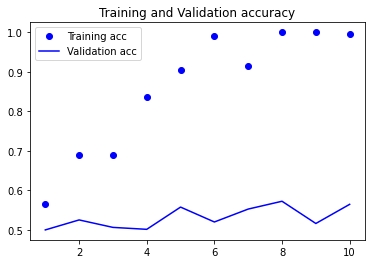

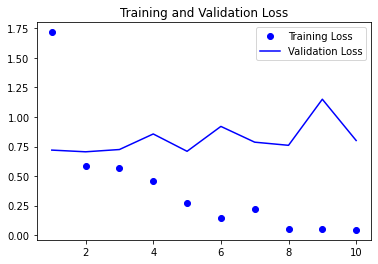

In [31]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title("Training and Validation accuracy")
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title("Training and Validation Loss")
plt.legend()

plt.show()

사전 훈련된 단어 임베딩을 사용하지 않고 같은 모델 훈련하기
- 검증 정확도가 50% 초반에 멈추어 있다.
- 이 예제는, 사전 훈련된 단어 임베딩을 사용하는 것이 함께 훈련하는 것보다 낫다
  - 훈련 샘플의 수를 늘리면 상황이 바뀐다.

In [33]:
## 사전 훈련된 단어 임베딩을 사용하지 않고 같은 모델 훈련하기

from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_val,y_val))

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 100, 100)          1000000   
                                                                 
 flatten_3 (Flatten)         (None, 10000)             0         
                                                                 
 dense_5 (Dense)             (None, 32)                320032    
                                                                 
 dense_6 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
7/7 [==============================] - 2s 253ms/step - loss: 0.6946 - acc: 0.5050 - val_loss: 0.6947 - val_acc: 0.5073
Epoch 2/10
7/7 [==============================

#### 결과 그래프 보기 : 학습 데이터만 활용하기
- 과대적합이 빠르게 시작되는 것을 알 수 있음
- 검증 정확도, 훈련 정확도와 큰 차이가 있음

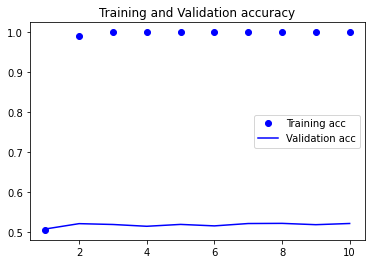

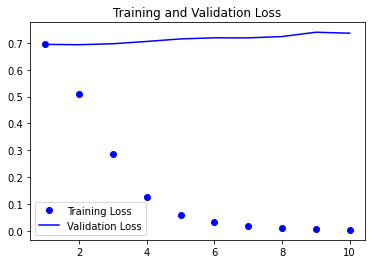

In [34]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title("Training and Validation accuracy")
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title("Training and Validation Loss")
plt.legend()

plt.show()

테스트 데이터 모델 평가

In [35]:
# 테스트 데이터 토큰화하기
test_dir = os.path.join(imdb_dir, 'test')

labels=[]
texts=[]

for label_type in ['neg','pos']:
  dir_name = os.path.join(test_dir, label_type)
  for fname in sorted(os.listdir(dir_name)):
    if fname[-4:]=='.txt':
      f = open(os.path.join(dir_name, fname), encoding='utf8')
      texts.append(f.read())
      f.close()
      if label_type == 'neg':
        labels.append(0)
      else:
        labels.append(1)

sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)

In [36]:
# 테스트 데이터에서 모델 평가하기
model.load_weights('pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)
# 정확도는 56%

782/782 [==============================] - 3s 4ms/step - loss: 0.8076 - acc: 0.5678


[0.8076450824737549, 0.567799985408783]

# 6.2. 순환 신경망 이해하기

- Fully Connected Network 나 ConvNet 은 메모리가 없다
  - 네트워크에 주입되는 입력은, 개별적으로 처리되며 입력 간에 유지되는 상태가 없다
  - 이런 네트워크로 시퀀스나 시계열 데이터를 처리하려면, 네트워크 전체 시퀀스를 주입해야한다
    - 즉, 전체 시퀀스를 하나의 데이터 포인트로 변환해야 한다
    - i.e. IMDB 문제에서 영화 리뷰 하나를 큰 벡터 하나로 변환하는 것
    - 이를 피드포워드 네트워크(feedforward network)이라고 한다.

- 순환 신경망 (Recurrent Neural Network, RNN)
  - 시퀀스의 원소를 순회하면서, 지금까지 처리한 정보를 상태에 저장한다
  - RNN은 크기가(timesteps, input_features)인 2D 텐서로 입력받는다
    - 각 타임스텝 t 에서 현재 상태와 (input_features, ) 크기의 입력을 연결하여 출력을 계산
    - 이 출력을 다음 스텝의 상태로 설정

- 의사코드로 표현한 RNN
```
state_t = 0 # 타임스텝 t 의 상태
for input_t in input_sequence : # 시퀀스의 원소를 반복한다
  output_t = f(input_t, state_t)
  state_t = output_ t # 출력은 다음 반복을 위한 상태
```
  - f 함수는 입력과 상태를 출력으로 변환한다.
  - 이를 2개의 행렬 W와 U 그리고 편향 벡터를 사용하는 변환으로 바꿀 수 있다.

- 좀 더 자세한 의사코드로 표현한 RNN
```
state_t = 0
for input_t in input_sequence:
  output_t = activation(dot(W, input_t) + dot(U, state_t) + b)
  state_t = output_t
```

In [38]:
# 넘파이로 구현한 간단한 RNN

import numpy as np

timesteps = 100
input_features = 32
output_features = 64

inputs = np.random.random((timesteps, input_features)) # 입력 데이터 : 예제를 위해 생성한 난수

state_t = np.zeros((output_features,)) # 초기 상태 : 모두 0 인 벡터

W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))

successive_outputs = []
for input_t in inputs:
  output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) +b)
  successive_outputs.append(output_t) # 출력 리스트에 저장
  state_t = output_t # 다음 타임스탭을 위해 업데이트

# 최종 출력은 크기가 (timesteps, output_features)인 2D텐서이다.
final_output_sequence = np.stack(successive_outputs, axis=0)


## 케라스의 순환 층
- SimpleRNN
  - 하나의 시퀀스가 아니라, 시퀀스 배치를 처리한다 
    - (batch_size, timesteps, input_features)
  

In [40]:
# Simple RNN을 사용하여 마지막 타임스텝의 출력만 얻는 예제

from keras.models import Sequential
from keras.layers import SimpleRNN, Embedding

model = Sequential()
model.add(Embedding(1000, 32))
model.add(SimpleRNN(32))
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, None, 32)          32000     
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 32)                2080      
                                                                 
Total params: 34,080
Trainable params: 34,080
Non-trainable params: 0
_________________________________________________________________


In [41]:
# Simple RNN을 사용하여 전체 상태 시퀀스 반환

from keras.models import Sequential
from keras.layers import SimpleRNN, Embedding

model = Sequential()
model.add(Embedding(1000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, None, 32)          32000     
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, None, 32)          2080      
                                                                 
Total params: 34,080
Trainable params: 34,080
Non-trainable params: 0
_________________________________________________________________


In [42]:
# 네트워크의 표현력을 증가시키기 위해 여러 순환 층을 쌓는 것이 유용할 떄 가 있음
  # 이런 설정에서는 중간층이 ** 전체 출력 시퀀스를 반환 ** 하도록 설정해야 함
model = Sequential()
model.add(Embedding(1000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32))
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, None, 32)          32000     
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, None, 32)          2080      
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, None, 32)          2080      
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, None, 32)          2080      
                                                                 
 simple_rnn_6 (SimpleRNN)    (None, 32)                2080      
                                                                 
Total params: 40,320
Trainable params: 40,320
Non-trainable params: 0
_________________________________________________________________


## IMDB 영화 리뷰 문제 적용

In [1]:
# 1. IMBDB 데이터 전처리하기
from keras.datasets import imdb
from keras.preprocessing import sequence

max_features = 10000    # --- 특성으로 사용할 단어의 수
maxlen = 500            # --- 사용할 텍스트의 길이 ( 가장 빈번한 max_features개의 단어만 사용)
batch_size = 32

print("데이터 로딩 ...")
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words = max_features)
print(len(input_train), '훈련 시퀀스')
print(len(input_test), '테스트 시퀀스')

print('시퀀스 패딩(samples x time)')
input_train = sequence.pad_sequences(input_train, maxlen=maxlen)
input_test = sequence.pad_sequences(input_test, maxlen=maxlen)
print("input_train 크기 :", input_train.shape)
print("input_test 크기 :", input_test.shape)
                                    

데이터 로딩 ...
17473536/17464789 [==============================] - 0s 0us/step
25000 훈련 시퀀스
25000 테스트 시퀀스
시퀀스 패딩(samples x time)
input_train 크기 : (25000, 500)
input_test 크기 : (25000, 500)


In [44]:
# 2. Embedding 층과 Simple RNN 층을 사용한 모델 훈련하기
from keras.layers import Dense

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)


Epoch 1/10
157/157 [==============================] - 39s 235ms/step - loss: 0.6254 - acc: 0.6409 - val_loss: 0.7860 - val_acc: 0.5688
Epoch 2/10
157/157 [==============================] - 38s 241ms/step - loss: 0.3871 - acc: 0.8359 - val_loss: 0.3537 - val_acc: 0.8556
Epoch 3/10
157/157 [==============================] - 32s 206ms/step - loss: 0.3032 - acc: 0.8793 - val_loss: 0.3634 - val_acc: 0.8478
Epoch 4/10
157/157 [==============================] - 33s 210ms/step - loss: 0.2471 - acc: 0.9044 - val_loss: 0.3682 - val_acc: 0.8472
Epoch 5/10
157/157 [==============================] - 25s 162ms/step - loss: 0.1752 - acc: 0.9350 - val_loss: 0.4906 - val_acc: 0.8058
Epoch 6/10
157/157 [==============================] - 26s 166ms/step - loss: 0.1289 - acc: 0.9540 - val_loss: 0.3969 - val_acc: 0.8476
Epoch 7/10
157/157 [==============================] - 25s 162ms/step - loss: 0.0836 - acc: 0.9738 - val_loss: 0.4838 - val_acc: 0.8120
Epoch 8/10
157/157 [==============================] - 2

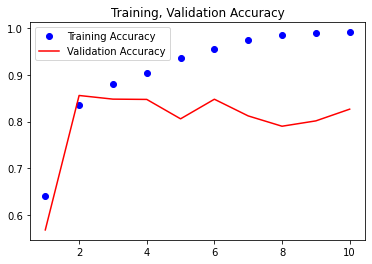

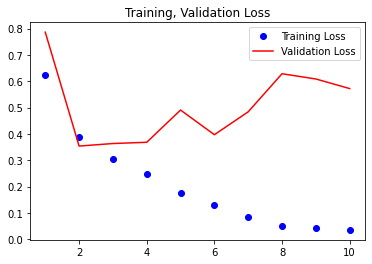

In [47]:
# 3. 결과 그래프 그리기
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs=range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo',color='b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b',color='r', label='Validation Accuracy')
plt.title('Training, Validation Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', color='b',label='Training Loss')
plt.plot(epochs, val_loss, 'b', color='r',label='Validation Loss')
plt.title('Training, Validation Loss')
plt.legend()
plt.show()

*** 결론 ***
- SimpleRNN 은 텍스트 같은 긴 시퀀스를 처리하기 적합하지 않다
- maxlen 을 500개만 사용하여 이전 모델에 비해 떨어진다 (약 85%)
- 다른 순환층이 더 적합하다!
  - LSTM, GRU

## LSTM, GRU 이해하기
- 질문-응답 / 기계 번역에 많이 사용됨

In [2]:
from keras.models import Sequential
from keras.layers import Embedding, Dense, LSTM

model = Sequential()
model.add(Embedding(max_features,32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

history = model.fit(input_train, y_train,
                    epochs= 10,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 57s 346ms/step - loss: 0.5028 - acc: 0.7611 - val_loss: 0.3536 - val_acc: 0.8550
Epoch 2/10
157/157 [==============================] - 54s 346ms/step - loss: 0.2985 - acc: 0.8828 - val_loss: 0.3748 - val_acc: 0.8322
Epoch 3/10
157/157 [==============================] - 54s 341ms/step - loss: 0.2327 - acc: 0.9122 - val_loss: 0.3296 - val_acc: 0.8644
Epoch 4/10
157/157 [==============================] - 53s 337ms/step - loss: 0.2012 - acc: 0.9250 - val_loss: 0.3259 - val_acc: 0.8722
Epoch 5/10
157/157 [==============================] - 55s 352ms/step - loss: 0.1819 - acc: 0.9342 - val_loss: 0.2951 - val_acc: 0.8822
Epoch 6/10
157/157 [==============================] - 53s 338ms/step - loss: 0.1565 - acc: 0.9449 - val_loss: 0.3293 - val_acc: 0.8586
Epoch 7/10
157/157 [==============================] - 56s 355ms/step - loss: 0.1478 - acc: 0.9488 - val_loss: 0.3282 - val_acc: 0.8772
Epoch 8/10
157/157 [==============================] - 6

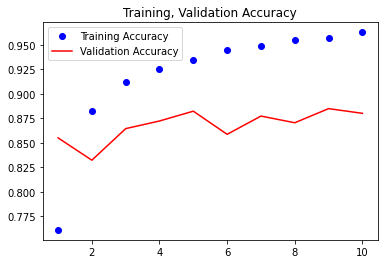

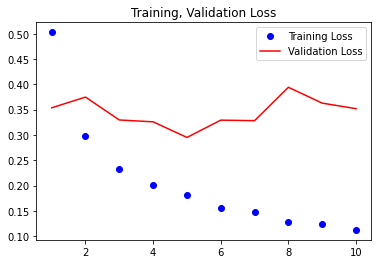

In [3]:
# 3. 결과 그래프 그리기
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs=range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo',color='b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b',color='r', label='Validation Accuracy')
plt.title('Training, Validation Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', color='b',label='Training Loss')
plt.plot(epochs, val_loss, 'b', color='r',label='Validation Loss')
plt.title('Training, Validation Loss')
plt.legend()
plt.show()

*** 결론 ***
- 훨씬 좋은 결과를 가지지만, 최대 단어의 수를 500개로 제한한 것,
- LSTM 은 텍스트 형에는 맞지 않다는 것 !을 알 수 있다

# 6.3 순환 신경망의 고급 사용법
- 순환 신경망의 성능과 일반화 능력을 향상시키는 방법
  - 순환 드롭아웃(recurrent dropout)
    - 순환 층에서 과대적합을 방지하기 위해 케라스에 내장되어 있는 드롭아웃을 사용
  - 스태킹 순환 층 (stacking recurrent layer)
    - 네트워크의 표현 능력(representational power)을 증가시킨다 (대신 계산 비용이 증가)
  - 양방향 순환 층(bidirectional recurrent layer) 
    - 순환 네트워크에 같은 정보를 다른 방향으로 주입하여 정확도를 높이고 기억을 좀 더 오래 유지시킨다.

    

## 기온예측 문제 : 시계열 데이터

In [4]:
!wget 'https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip'

--2021-12-20 12:06:15--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.195.48
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.195.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  16.9MB/s    in 0.8s    

2021-12-20 12:06:16 (16.9 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]



In [5]:
!unzip jena_climate_2009_2016.csv.zip

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


In [16]:
import pandas as pd
df = pd.read_csv(fname)
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


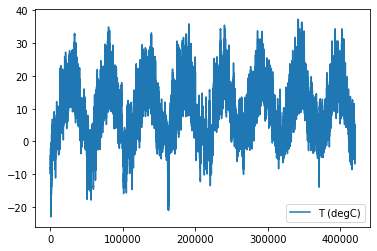

In [18]:
df[['T (degC)']].plot()

In [9]:
# 1. 날씨 데이터셋 조사히기
import os
data_dir = '/content/'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [11]:
# 2. 데이터 파싱하기
import numpy as np

float_data = np.zeros((len(lines), len(header)-1))
for i, line in enumerate(lines):
  values = [float(x) for x in line.split(',')[1:]]
  float_data[i, :] = values

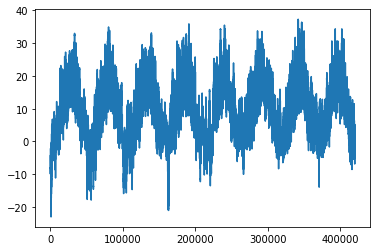

In [12]:
# 시계열 온도 그래프 그리기
from matplotlib import pyplot as plt
temp = float_data[:, 1] # 온도 섭씨
plt.plot(range(len(temp)), temp)

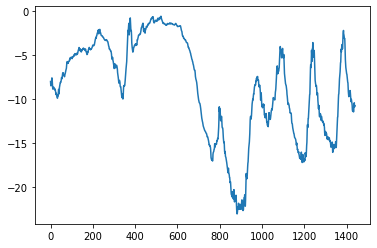

In [13]:
# 처음 10일 간 온도 그래프 그리기
plt.plot(range(1440), temp[:1440])

### 목표 : 일자별 수준의 시계열 데이터 예측하기

### 데이터 준비
- lookback (타입스텝) = 1440 : 10일 전 데이터로 돌아간다 (10분간격, 1시간 6회, 24* 6 * 10)
- steps = 6 : 1시간마다 데이터 포인트 하나를 샘플링
- delay = 144 : 24시간이 지난 데이터가 타깃이 된다


- 신경망에 주입할 수 있는 형태로 데이터를 전처리
  - i.e. 온도는 -20~+30 사이 // 밀리바(mb)는 1,000 근처의 값
- float_data 배열을 받아 과거 데이터의 배치와 미래 타깃 온도를 추출하는 파이썬 제너레이터 생성
  - 이 데이터셋은 중복이 많다
  - 따라서 원본 데이터를 사용하여 그때 그때 배치를 만든다.


- 각 시계열 특성에 대해 평균을 빼고, 표준편차로 나누어 전처리 해준다.

In [19]:
# 3. 데이터 정규화하기
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [43]:
# 제네레이터 함수는 (samples, targets) 튜플을 반복적으로 반환
# samples 는 입력데이터로 사용할 배치  -> (128, 240, 14)
# targets 는 이에 대응되는 타깃 온도의 배열 -> (128,)

# 제네레이터 함수에는 다음의 매개변수를 가짐
  # data : 정규화한 부동 소수 데이터로 이루어진 원본 배열
  # lookback : 입력으로 사용하기 위해 거슬러 올라갈 타임스텝
  # delay : 타깃으로 사용할 미래의 타임스텝
  # min_index / max_index : 추출할 타임스텝의 범위를 지정하기 위한 data 배열의 인덱스
  # shuffle : 샘플을 섞을지, 시간 순서대로 할지
  # batch_size : 배치의 샘플 수
  # step : 데이터를 샘플링할 타임스텝 간격 -> 1시간에 1개의 데이터 포인트이므로, 6으로 지정

# 4. 데이터 제너레이터 함수
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
  if max_index is None:
    max_index = len(data)-delay-1
  i = min_index + lookback
  while True:
    if shuffle:
      rows = np.random.randint(min_index+lookback, max_index, size=batch_size) # batch_size 크기만큼 최소, 최대 값을 랜덤하게 rows 에 저장 (샘플을 랜덤하게 섞어줌)
    else:
      if i+batch_size >= max_index:
        i = min_index + lookback
      rows = np.arange(i, min(i+batch_size, max_index))
      i+= len(rows)
    
    samples = np.zeros((len(rows),
                        lookback // step,
                        data.shape[-1]))
    targets = np.zeros((len(rows),))
    for j,row in enumerate(rows):
      indices = range(rows[j] - lookback, rows[j], step)
      samples[j] = data[indices]
      targets[j] = data[rows[j] + delay][1]
    yield samples, targets


In [44]:
# 5. 훈련, 검증, 테스트 제너레이터 준비
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback= lookback,
                      delay = delay,
                      min_index= 0,
                      max_index = 200000,
                      shuffle=True,
                      step = step,
                      batch_size = batch_size)

val_gen = generator(float_data,
                      lookback= lookback,
                      delay = delay,
                      min_index= 200001,
                      max_index = 300000,
                      step = step,
                      batch_size = batch_size)

test_gen = generator(float_data,
                      lookback= lookback,
                      delay = delay,
                      min_index= 300001,
                      max_index = None,
                      step = step,
                      batch_size = batch_size)

# 전체 검증 세트를 순회하기 위해 val_gen 에서 추출할 횟수
val_steps = (300000 - 200001 - lookback) // batch_size

# 전체 테스트 세트를 순회하기 위해 test_gen 에서 추출할 횟수
test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [33]:
# 상식 기준 모델의 MAE 계산하기
def evaluate_naive_method():
  batch_maes = []
  for step in range(val_steps):
    samples, targets = next(val_gen)
    preds = samples[:, -1, 1]
    mae = np.mean(np.abs(preds - targets))
    batch_maes.append(mae)
  print(np.mean(batch_maes))

evaluate_naive_method()

0.2897359729905486


In [40]:
# 평균 절댓값 오차
celsius_mae = 0.29 * std[1]
celsius_mae

2.5672247338393395

In [45]:
# 6. 기본적인 머신 러닝 방법
from keras.models import Sequential
from keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')

history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data = val_gen,
                              validation_steps = val_steps)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/20
500/500 [==============================] - 31s 62ms/step - loss: 1.4229 - val_loss: 0.7286
Epoch 2/20
500/500 [==============================] - 33s 65ms/step - loss: 0.4548 - val_loss: 0.3675
Epoch 3/20
500/500 [==============================] - 27s 55ms/step - loss: 0.3073 - val_loss: 0.3206
Epoch 4/20
500/500 [==============================] - 27s 55ms/step - loss: 0.2756 - val_loss: 0.3107
Epoch 5/20
500/500 [==============================] - 24s 47ms/step - loss: 0.2612 - val_loss: 0.3186
Epoch 6/20
500/500 [==============================] - 18s 37ms/step - loss: 0.2514 - val_loss: 0.3010
Epoch 7/20
500/500 [==============================] - 18s 37ms/step - loss: 0.2460 - val_loss: 0.3176
Epoch 8/20
500/500 [==============================] - 16s 32ms/step - loss: 0.2392 - val_loss: 0.3427
Epoch 9/20
500/500 [==============================] - 16s 32ms/step - loss: 0.2337 - val_loss: 0.3173
Epoch 10/20
500/500 [==============================] - 17s 33ms/step - loss: 0.230

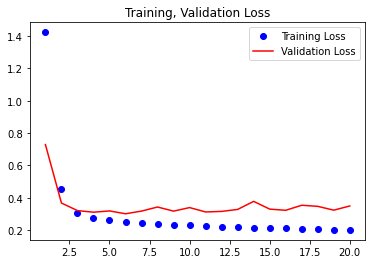

In [46]:
# 7. 결과 그래프 그리기
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss)+1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', color='r', label='Validation Loss')
plt.legend()
plt.title("Training, Validation Loss")

plt.show()

#### 결과
- 일부 검증 손실은 안정적이지 못함
- 시계열 데이터를 펼쳤기 때문에, 입력 데이터에서 시간 개념을 잃어버렸음
  - 대신 인과 관계와 순서가 의미 있는 시퀀스 데이터를 그대로 사용함
- "가설 공간" 은 우리가 매개변수로 설정한 2개 층을 가진 네트워크의 모든 가능한 가중치 조합이다
  - 이미 충분히 복잡하기 때문에, 괜찮은 성능을 내지 못할 수 있음

### GRU
- LSTM 과 같은 원리로 작동하지만, 조금 더 간결하고 계산 비용이 덜 든다.

In [47]:
from keras.models import Sequential
from keras.layers import Dense, GRU
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')

history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data = val_gen,
                              validation_steps = val_steps)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  from ipykernel import kernelapp as app


Epoch 1/20
500/500 [==============================] - 94s 182ms/step - loss: 0.3019 - val_loss: 0.2704
Epoch 2/20
500/500 [==============================] - 93s 186ms/step - loss: 0.2855 - val_loss: 0.2657
Epoch 3/20
500/500 [==============================] - 91s 182ms/step - loss: 0.2798 - val_loss: 0.2652
Epoch 4/20
500/500 [==============================] - 90s 179ms/step - loss: 0.2737 - val_loss: 0.2627
Epoch 5/20
500/500 [==============================] - 90s 179ms/step - loss: 0.2686 - val_loss: 0.2634
Epoch 6/20
500/500 [==============================] - 90s 179ms/step - loss: 0.2656 - val_loss: 0.2658
Epoch 7/20
500/500 [==============================] - 89s 177ms/step - loss: 0.2623 - val_loss: 0.2677
Epoch 8/20
500/500 [==============================] - 91s 182ms/step - loss: 0.2566 - val_loss: 0.2656
Epoch 9/20
500/500 [==============================] - 90s 180ms/step - loss: 0.2523 - val_loss: 0.2705
Epoch 10/20
500/500 [==============================] - 89s 178ms/step - l

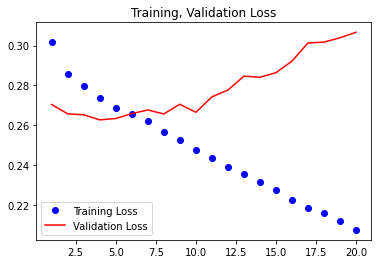

In [48]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss)+1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', color='r', label='Validation Loss')
plt.legend()
plt.title("Training, Validation Loss")

plt.show()

### 순환 드롭아웃 사용하기
- 과대적합 감소시키기 
- 타임스텝마다 랜덤하게 드롭아웃 마스크를 바꾸는 것이 아니라, 동일한 드롭아웃 마스크를 모든 타임스텝에 적용해야 한다
- LSTM, GRU같은 순환 게이트에 사용하려면, 타임스텝ㅁ마다 동일한 드롭아웃 마스크를 적용해야 한다.
  - 모든 타임스텝에 동일한 드롭아웃 마스크를 적용하여, 네트워크가 학습 오차를 타임스텝에 걸쳐 적절하게 전파시켜준다
- *** 랜덤한 드롭아웃 마스크를 적용하면 오차 신호가 전파되는 것을 방해한다 ***


- recurrent_dropout 은 순환 상태의 드롭아웃 비율을 정한다.
- GRU  층에 드롭아웃, 순환 드롭아웃을 적용해보자

In [51]:
from keras.models import Sequential
from keras.layers import GRU, Dense
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(GRU(32, 
              dropout=0.2, 
              recurrent_dropout=0.2,
              input_shape = (None, float_data.shape[-1])))
model.add(Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')

history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data = val_gen,
                              validation_steps = val_steps)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/40
500/500 [==============================] - 184s 360ms/step - loss: 0.3269 - val_loss: 0.2750
Epoch 2/40
500/500 [==============================] - 198s 396ms/step - loss: 0.3048 - val_loss: 0.2716
Epoch 3/40
500/500 [==============================] - 152s 304ms/step - loss: 0.2982 - val_loss: 0.2709
Epoch 4/40
500/500 [==============================] - 152s 304ms/step - loss: 0.2936 - val_loss: 0.2789
Epoch 5/40
500/500 [==============================] - 154s 309ms/step - loss: 0.2896 - val_loss: 0.2730
Epoch 6/40
500/500 [==============================] - 154s 307ms/step - loss: 0.2843 - val_loss: 0.2704
Epoch 7/40
500/500 [==============================] - 150s 300ms/step - loss: 0.2802 - val_loss: 0.2718
Epoch 8/40
500/500 [==============================] - 150s 300ms/step - loss: 0.2775 - val_loss: 0.2692
Epoch 9/40
500/500 [==============================] - 151s 301ms/step - loss: 0.2748 - val_loss: 0.2770
Epoch 10/40
500/500 [==============================] - 150s 301m

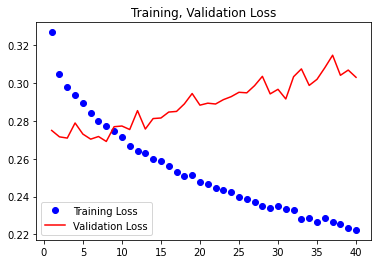

In [52]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss)+1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', color='r', label='Validation Loss')
plt.legend()
plt.title("Training, Validation Loss")

plt.show()

#### 결과
과대적합이 준것을 확인

### 스태킹 순환 층

- 과대적합을 줄였으면? 과대적합이 일어날 때 까지 네트워크의 용량을 늘려준다
- 너무 많이 과대적합되지 않는 한, 아직 늘려줄 수 있음

- 네트워크의 용량 늘리는 방법
  - 층의 유닛 수를 늘리거나
  - 층을 더 추가해준다

In [ ]:
from keras.models import Sequential
from keras.layers import GRU, Dense
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(GRU(32,
              dropout=0.1,
              recurrent_dropout=0.5,
              return_sequences=True,
              input_shape=(None, float_data.shape[-1])))
model.add(GRU(64, activation='relu',
              dropout=0.1, recurrent_dropout=0.5))
model.add(Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')

history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data = val_gen,
                              validation_steps = val_steps)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/40
500/500 [==============================] - 414s 817ms/step - loss: 0.3228 - val_loss: 0.2755
Epoch 2/40
500/500 [==============================] - 409s 819ms/step - loss: 0.3008 - val_loss: 0.2727
Epoch 3/40
500/500 [==============================] - 409s 817ms/step - loss: 0.2934 - val_loss: 0.2677
Epoch 4/40
500/500 [==============================] - 409s 818ms/step - loss: 0.2870 - val_loss: 0.2826
Epoch 5/40
500/500 [==============================] - 409s 819ms/step - loss: 0.2795 - val_loss: 0.2733
Epoch 6/40
500/500 [==============================] - 410s 820ms/step - loss: 0.2735 - val_loss: 0.2726
Epoch 7/40
500/500 [==============================] - 411s 822ms/step - loss: 0.2681 - val_loss: 0.2799
Epoch 8/40
500/500 [==============================] - 410s 820ms/step - loss: 0.2618 - val_loss: 0.2831
Epoch 9/40
500/500 [==============================] - 409s 819ms/step - loss: 0.2586 - val_loss: 0.2894
Epoch 10/40
500/500 [==============================] - 411s 822m

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss)+1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', color='r', label='Validation Loss')
plt.legend()
plt.title("Training, Validation Loss")

plt.show()

#### 결과
- 층을 추가하여 성능이 조금 향상됨
- 결론
  - 아직 충분히 과대적합을 만들지 못했기 때문에 층의 크기를 더 늘릴 수 있다 ( 단, 적지 않은 계산 비용이 추가된다)
  - 층을 추가했는데도 불구하고, 큰 성능의 개선이 이루어지지 않음
    - 즉, 네트워크의 용량을 늘리는 것이 도움이 되지 않음

### 양방향 RNN 사용하기 
- bidirectional RNN
  - 각 RNN은 입력 시퀀스를 한 방향으로 처리하여 각 표현을 합친다
  - 시퀀스를 양쪽 방향으로 처리하여 단방향 RNN 이 놓치기 쉬운 패턴을 감지해준다.
  